In [1]:
import csv
import sklearn

import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import umap.umap_ as umap
from scipy.linalg import eigh as largest_eigh
from scipy.linalg import orthogonal_procrustes

In [2]:
HiC_Exc = pd.read_csv("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/SAI_results/single_cell_eigens/Exc/eigen.txt", sep='\t', names=["chr", "start", "end", "compartment", "eigen"], index_col=False)
bin_df = pd.read_csv("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/gap.blacklist.hg38.1000000.4col.autosomal.bed", sep='\t', names=["chr","start","end","name"])
delete_bins = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Cross-Sample/1000K_resolution/delete_bins.npy")
bin_df_new = bin_df.drop(delete_bins).reset_index(drop=True)
CON_Exc_feature = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Cross-Sample/1000K_resolution/3_CON/cell_type/Exc/raw/feature.npy")
PTSD_Exc_feature = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Cross-Sample/1000K_resolution/2_PTSD/cell_type/Exc/raw/feature.npy")

In [3]:
bin_df_new.loc[228,:]

chr          chr2
start    15000000
end      16000000
name      chr2_16
Name: 228, dtype: object

Ast
0.6287362 0.46673470735549927
15952.357826253348 11513.635207823962
228 #6e896a -1.5602504 6.0938745
2557 #6e896a -0.97668993 4.8204875


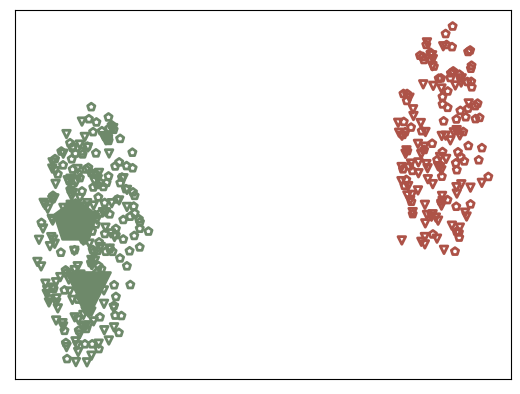

End
0.49385384 0.3897300362586975
1806.948679245283 2653.6240039840636
228 #6e896a 0.87506 0.5343826
2557 #6e896a 1.498729 0.57027465


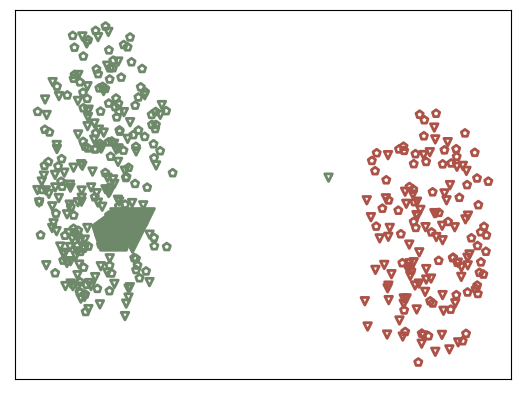

Exc
0.789621 0.5459831655025482
65862.25757575757 105434.23975409837
228 #ad5247 6.228125 2.665518
2557 #6e896a 10.572667 2.5374763


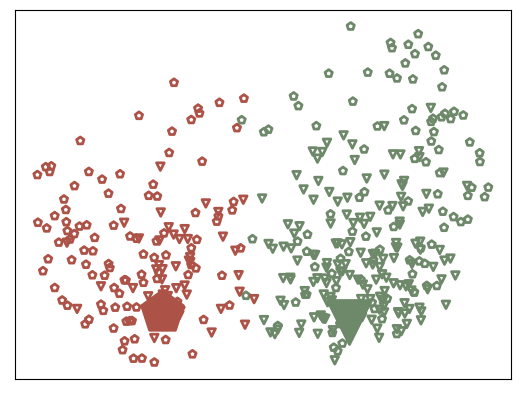

Inh
0.62524885 0.46487176418304443
16408.522143654634 23560.73769660071
228 #6e896a 13.506192 7.379767
2557 #6e896a 11.936679 7.6178217


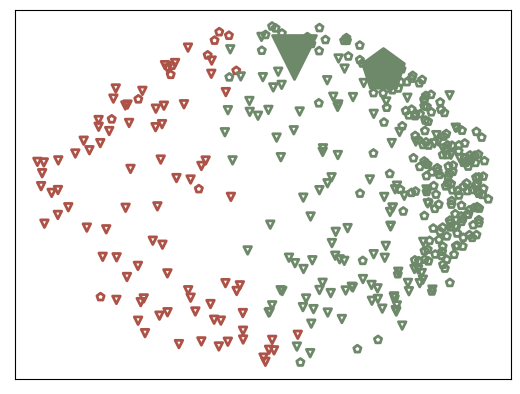

Mic
0.6715064 0.4890616536140442
5126.924391130498 10058.267960146828
228 #6e896a 8.435698 2.3314352
2557 #6e896a 8.694752 -0.22382273


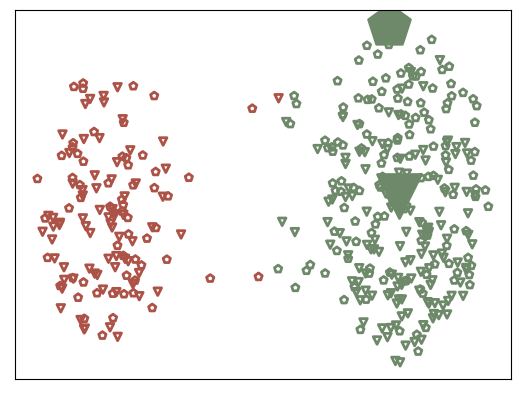

Olig
0.6345482 0.46982502937316895
18214.025399129172 41803.09726603575
228 #6e896a 5.735208 2.3646789
2557 #6e896a 8.140901 5.8146424


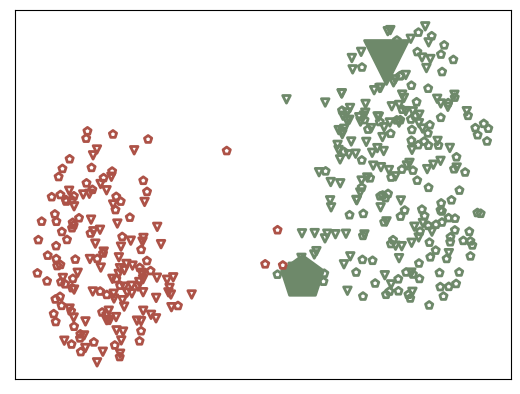

OPC
0.6747635 0.4907231330871582
4951.722129783694 8747.966122202057
228 #6e896a -0.12027959 2.0952024
2557 #6e896a 4.6834655 0.6403707


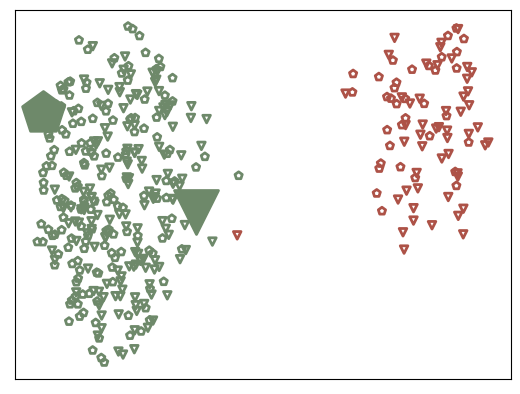

In [14]:
embedding_size = 32

chr_start = 218
chr_end = 421
key_point = 228 - chr_start
metacell = 200

for cell_type in ["Ast", "End", "Exc", "Inh", "Mic", "Olig", "OPC"]:
# for cell_type in ["Exc"]:
    
    print(cell_type)
    
    CON_emb = np.load("/auto/grad_space/zihend1/scENCORE/Change_Resolution/1000K/3_CON/cell_type/"+cell_type+"/"+str(metacell)+"_metacell/Embedding/corr_0_1_VERSE_"+str(embedding_size)+".npy")
    MDD_emb = np.load("/auto/grad_space/zihend1/scENCORE/Change_Resolution/1000K/2_MDD/cell_type/"+cell_type+"/"+str(metacell)+"_metacell/Embedding/corr_0_1_VERSE_"+str(embedding_size)+".npy")
#     PTSD_emb = np.load("/auto/grad_space/zihend1/scENCORE/Change_Resolution/1000K/2_PTSD/cell_type/"+cell_type+"/"+str(metacell)+"_metacell/Embedding/corr_0_1_VERSE_32.npy")
    
    CON_feature = np.load("/auto/grad_space/zihend1/scENCORE/Change_Resolution/1000K/3_CON/cell_type/"+cell_type+"/raw/feature.npy")
    MDD_feature = np.load("/auto/grad_space/zihend1/scENCORE/Change_Resolution/1000K/2_MDD/cell_type/"+cell_type+"/raw/feature.npy")
#     PTSD_feature = np.load("/auto/grad_space/zihend1/scENCORE/Change_Resolution/1000K/2_PTSD/cell_type/"+cell_type+"/raw/feature.npy")
    
    R, _ = orthogonal_procrustes(MDD_emb, CON_emb)
    transfer_MDD_emb = MDD_emb @ R
    
    #     R, _ = orthogonal_procrustes(PTSD_emb, CON_emb)
#     transfer_PTSD_emb = PTSD_emb @ R

    CON_emb = (CON_emb-np.min(CON_emb))/(np.max(CON_emb)-np.min(CON_emb))
    transfer_MDD_emb = (transfer_MDD_emb-np.min(transfer_MDD_emb))/(np.max(transfer_MDD_emb)-np.min(transfer_MDD_emb))
    D = np.sqrt((np.sum((transfer_MDD_emb[228,:] - CON_emb[228,:])**2)))
    CSS = 1-np.exp(-D)
    print(D, CSS)
    
    #     embedding = np.vstack((CON_emb, transfer_PTSD_emb))
    embedding = np.vstack((CON_emb, transfer_MDD_emb))
    # embedding = CON_emb
    adata = ad.AnnData(embedding)
    sc.pp.neighbors(adata, n_neighbors=100, use_rep='X')
    sc.tl.leiden(adata,resolution=0.5)
    sc.tl.umap(adata)
    # adata.obs['eigen'] = np.vstack((CON_Exc_eigen, PTSD_Exc_eigen))
#     fig = sc.pl.umap(adata, color='leiden', return_fig=True)
    # fig = sc.pl.umap(adata, color='eigen', return_fig=True)
    # fig.savefig('before_alignment.eps',dpi=1000,format='eps')
#     plt.show()
    
    pos = np.array(adata.obsm['X_umap'])
    color_array = np.array(adata.obs["leiden"], dtype=np.int32)
#     total_feature = np.hstack((np.sum(CON_feature, axis=0), np.sum(PTSD_feature, axis=0)))
    total_feature = np.hstack((np.sum(CON_feature, axis=0), np.sum(MDD_feature, axis=0)))
    
    print(np.mean(total_feature[np.where(color_array==0)]),np.mean(total_feature[np.where(color_array==1)]))
    
    color_list = []
    size_list = []
    linewidths_list = []


    for i in range(color_array.shape[0]):
        if (i>=chr_start and i<chr_end) or (i>=chr_start+2329 and i<chr_end+2329):
            size_list.append(70)
            linewidths_list.append(2)
            if color_array[i] == 1:
                color_list.append("#ad5247")
            else:
                color_list.append("#6e896a")
        else:
            size_list.append(5)
            linewidths_list.append(1)
            color_list.append("#C0C0C0")
            
    edgecolors_list = color_list
    non_color_list = ['none' for i in range(color_array.shape[0])]
    

#     show_background = True
    show_background = False
    for i in range(color_array.shape[0]):
        if i<2329:
            if show_background:
                if i==chr_start+key_point:
                    pass
                elif (i>=chr_start and i<chr_end):
                    pass
                else:
                    plt.scatter(pos[i,0], pos[i,1], s=10, color=non_color_list[i], marker="p", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
            else:
                if i==chr_start+key_point:
                    print(i,edgecolors_list[i], pos[i,0], pos[i,1])
                    plt.scatter(pos[i,0], pos[i,1], s=1000, color=edgecolors_list[i], marker="p", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
                elif (i>=chr_start and i<chr_end):
                    plt.scatter(pos[i,0], pos[i,1], s=30, color=non_color_list[i], marker="p", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
                else:
                    pass
        else:
            if show_background:
                if i==chr_start+key_point+2329:
                    pass
                elif (i>=chr_start+2329 and i<chr_end+2329):
                    pass
                else:
                    plt.scatter(pos[i,0], pos[i,1], s=10, color=non_color_list[i], marker="v", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i]) 
            else:
                if i==chr_start+key_point+2329:
                    print(i,edgecolors_list[i], pos[i,0], pos[i,1])
                    plt.scatter(pos[i,0], pos[i,1], s=1000, color=edgecolors_list[i], marker="v", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
                elif (i>=chr_start+2329 and i<chr_end+2329):
                    plt.scatter(pos[i,0], pos[i,1], s=30, color=non_color_list[i], marker="v", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
                else:
                    pass
    # plt.scatter(pos[:,0], pos[:,1], s=size_list, color=non_color_list, marker="o", edgecolors=edgecolors_list, linewidths=linewidths_list)
    # plt.savefig('CON_Exc_chr10.eps',dpi=1000,format='eps')
    # plt.savefig('CON_Exc_background_chr10.eps',dpi=1000,format='eps')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
#     if show_background:
#         plt.savefig("./Figure6/"+cell_type+'background.eps',dpi=1000,format='eps')
#     else:
#         plt.savefig("./Figure6/"+cell_type+'_target.eps',dpi=1000,format='eps')
    plt.show()

In [22]:
CON_emb = np.load("/auto/grad_space/zihend1/scENCORE/Change_Resolution/100K/3_CON/cell_type/"+cell_type+"/"+str(metacell)+"_metacell/Embedding/corr_0_1_VERSE_"+str(embedding_size)+".npy")

In [23]:
CON_emb.shape

(26054, 32)